In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
!cp "/content/mydrive/MyDrive/turbulence_dataset_sabl2048high_composite_label.pt.zip" "/content/"

In [ ]:
!unzip -o turbulence_dataset_sabl2048high_composite_label.pt.zip

Archive:  turbulence_dataset_sabl2048high_composite_label.pt.zip
  inflating: turbulence_dataset_sabl2048high_composite_label.pt  
  inflating: __MACOSX/._turbulence_dataset_sabl2048high_composite_label.pt  


In [ ]:
from transformers import PerceiverFeatureExtractor, PerceiverForImageClassificationConvProcessing

In [ ]:
!pip show transformers

Name: transformers
Version: 4.52.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [ ]:
import torch
import torch.nn as nn
from transformers import PerceiverForImageClassificationLearned, PerceiverImageProcessor
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import os

# ---------------------------
# Configuration
# ---------------------------
class Config:
    DATA_PATH = "turbulence_dataset_sabl2048high_composite_label.pt"
    CHECKPOINT_PATH = "/content/drive/MyDrive/turbulence_perceiverio_balancedData/perceiver_pretrained.pt"
    LOG_DIR = "/content/drive/MyDrive/turbulence_perceiverio_balancedData/logs_pretrained"
    BATCH_SIZE = 2
    EPOCHS = 5
    LR = 2e-5
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_CLASSES = 2

os.makedirs(Config.LOG_DIR, exist_ok=True)

# ---------------------------
# Dataset
# ---------------------------
class TurbulenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.to_img = transforms.ToPILImage()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if x.dim() == 4:
            x = x.squeeze(0)
        img = self.to_img(x)
        x = self.transform(img)
        return x, self.y[idx]

# ---------------------------
# Load Data
# ---------------------------
data = torch.load(Config.DATA_PATH)
X, y = data['X'], data['y']

# Balance dataset (optional)
turb_idx = (y == 1).nonzero(as_tuple=True)[0]
non_turb_idx = (y == 0).nonzero(as_tuple=True)[0]
non_turb_idx = non_turb_idx[torch.randperm(len(non_turb_idx))[:len(turb_idx)]]
final_idx = torch.cat([turb_idx, non_turb_idx])
final_idx = final_idx[torch.randperm(len(final_idx))]

X = X[final_idx]
y = y[final_idx]

# Dataset
dataset = TurbulenceDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=Config.BATCH_SIZE, shuffle=False)

# ---------------------------
# Model Setup
# ---------------------------
model = PerceiverForImageClassificationLearned.from_pretrained(
    "deepmind/vision-perceiver-learned",
    ignore_mismatched_sizes=True,
    num_labels=Config.NUM_CLASSES
)
model.to(Config.DEVICE)

optimizer = AdamW(model.parameters(), lr=Config.LR)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter(Config.LOG_DIR)

# ---------------------------
# Training Loop
# ---------------------------
best_val_acc = 0
for epoch in range(1, Config.EPOCHS + 1):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(Config.DEVICE), y_batch.to(Config.DEVICE)

        outputs = model(pixel_values=X_batch).logits
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(Config.DEVICE), y_batch.to(Config.DEVICE)

            outputs = model(pixel_values=X_batch).logits
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), Config.CHECKPOINT_PATH)
        print(f"\n💾 Saved Best Model at Epoch {epoch} with Val Accuracy {val_acc:.4f}")

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)

    print(f"Epoch {epoch}/{Config.EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

writer.close()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/249M [00:00<?, ?B/s]

Some weights of PerceiverForImageClassificationLearned were not initialized from the model checkpoint at deepmind/vision-perceiver-learned and are newly initialized because the shapes did not match:
- perceiver.decoder.decoder.final_layer.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- perceiver.decoder.decoder.final_layer.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/249M [00:00<?, ?B/s]


💾 Saved Best Model at Epoch 1 with Val Accuracy 0.8833
Epoch 1/5 | Train Loss: 0.4077 | Val Loss: 0.2713 | Train Acc: 0.8078 | Val Acc: 0.8833
Epoch 2/5 | Train Loss: 0.2521 | Val Loss: 0.3264 | Train Acc: 0.8949 | Val Acc: 0.8565

💾 Saved Best Model at Epoch 3 with Val Accuracy 0.9039
Epoch 3/5 | Train Loss: 0.1683 | Val Loss: 0.2355 | Train Acc: 0.9354 | Val Acc: 0.9039

💾 Saved Best Model at Epoch 4 with Val Accuracy 0.9255
Epoch 4/5 | Train Loss: 0.1227 | Val Loss: 0.2055 | Train Acc: 0.9532 | Val Acc: 0.9255

💾 Saved Best Model at Epoch 5 with Val Accuracy 0.9257
Epoch 5/5 | Train Loss: 0.0978 | Val Loss: 0.1860 | Train Acc: 0.9652 | Val Acc: 0.9257



📊 Classification Report:

               precision    recall  f1-score   support

Non-Turbulent       0.90      0.95      0.93      2235
    Turbulent       0.95      0.90      0.92      2273

     accuracy                           0.93      4508
    macro avg       0.93      0.93      0.93      4508
 weighted avg       0.93      0.93      0.93      4508



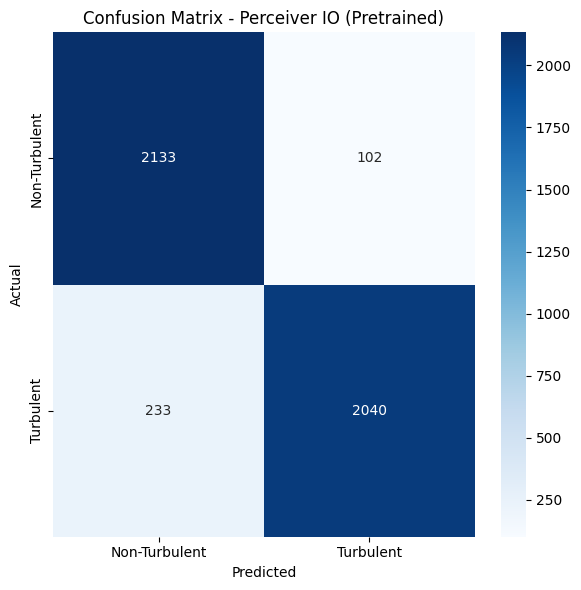

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

# ---------------------------
# Inference & Evaluation
# ---------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(Config.DEVICE)
        outputs = model(pixel_values=X_batch).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

# ---------------------------
# Metrics
# ---------------------------
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Non-Turbulent", "Turbulent"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Turbulent", "Turbulent"], yticklabels=["Non-Turbulent", "Turbulent"])
plt.title("Confusion Matrix - Perceiver IO (Pretrained)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
# Load model with attentions
model = PerceiverForImageClassificationLearned.from_pretrained(
    "deepmind/vision-perceiver-learned",
    output_attentions=True,
    ignore_mismatched_sizes=True,
    num_labels=2
).eval().to("cuda")

# Load processor
processor = PerceiverImageProcessor.from_pretrained("deepmind/vision-perceiver-learned")

# Dummy sample (or pick a real one from your val_set and resize to 224x224)
dummy = torch.rand(1, 3, 224, 224).to("cuda")

# Forward pass
with torch.no_grad():
    outputs = model(pixel_values=dummy)

# Check keys
print(outputs.keys())

Some weights of PerceiverForImageClassificationLearned were not initialized from the model checkpoint at deepmind/vision-perceiver-learned and are newly initialized because the shapes did not match:
- perceiver.decoder.decoder.final_layer.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- perceiver.decoder.decoder.final_layer.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

odict_keys(['logits', 'attentions', 'cross_attentions'])


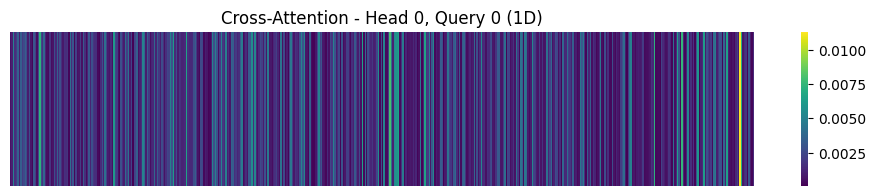

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 2))
sns.heatmap(attn_map.unsqueeze(0).cpu().numpy(), cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title("Cross-Attention - Head 0, Query 0 (1D)")
plt.show()


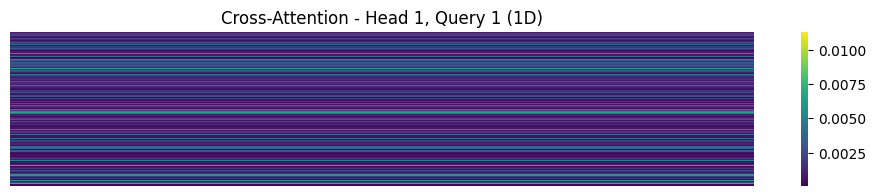

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 2))
sns.heatmap(attn_map.unsqueeze(1).cpu().numpy(), cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title("Cross-Attention - Head 1, Query 1 (1D)")
plt.show()


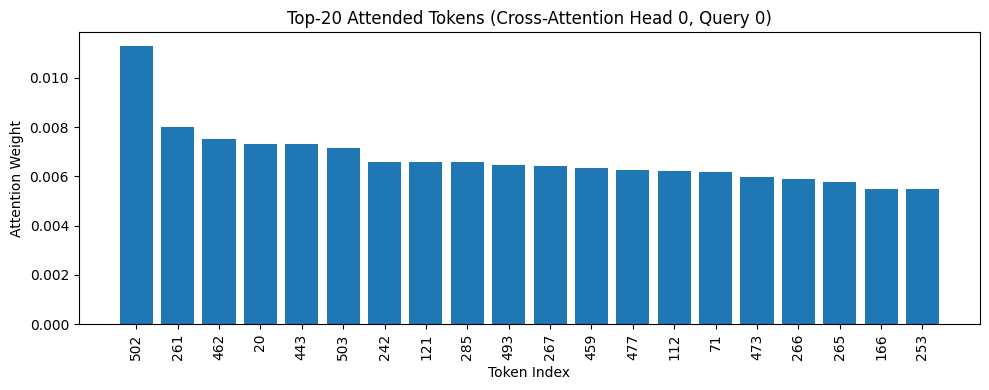

In [ ]:
import matplotlib.pyplot as plt
import torch

# Use the same attn_map from the previous extraction
topk = 20
values, indices = torch.topk(attn_map, topk)

# Plot top-k attention weights
plt.figure(figsize=(10, 4))
plt.bar(range(topk), values.detach().cpu().numpy())
plt.xticks(range(topk), indices.detach().cpu().numpy(), rotation=90)
plt.title(f"Top-{topk} Attended Tokens (Cross-Attention Head 0, Query 0)")
plt.xlabel("Token Index")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np

# Ensure model is in eval mode
model.eval()

correct_sample = None
correct_label = None

# Loop through validation set
for X_batch, y_batch in val_loader:
    X_batch = X_batch.to(Config.DEVICE)
    y_batch = y_batch.to(Config.DEVICE)

    with torch.no_grad():
        outputs = model(pixel_values=X_batch).logits
        preds = torch.argmax(outputs, dim=1)

        for i in range(len(y_batch)):
            if preds[i] == 1 and y_batch[i] == 1:
                correct_sample = X_batch[i].unsqueeze(0)  # Shape: [1, 3, 224, 224]
                correct_label = y_batch[i].item()
                print(f"✅ Found correctly classified turbulent sample at index {i}")
                break
    if correct_sample is not None:
        break

# Confirm shape
print(f"Sample shape: {correct_sample.shape}, Label: {correct_label}")


✅ Found correctly classified turbulent sample at index 0
Sample shape: torch.Size([1, 3, 224, 224]), Label: 1


In [ ]:
!pip install shap --quiet

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def predict_fn_shap(images):
    inputs = processor(images=[Image.fromarray(img.astype(np.uint8)) for img in images], return_tensors="pt").to("cpu")
    model_cpu = model.to("cpu")
    with torch.no_grad():
        outputs = model_cpu(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probs


In [ ]:
background = np.zeros((1, 224, 224, 3), dtype=np.uint8)
# Convert tensor to numpy image
img_np = correct_sample.squeeze(0).permute(1, 2, 0).cpu().numpy()
img_np = 255 * (img_np - img_np.min()) / (img_np.max() - img_np.min())
img_np = img_np.astype(np.uint8)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:47, 707.20s/it]              


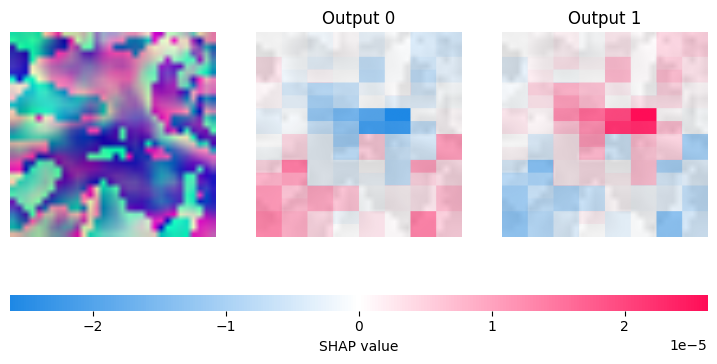

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Step 1: Prediction function for SHAP
def predict_fn_shap(images):
    inputs = processor(images=[Image.fromarray(img.astype(np.uint8)) for img in images], return_tensors="pt").to("cpu")
    with torch.no_grad():
        outputs = model.cpu()(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probs

# Step 2: Prepare image and background
img_np = correct_sample.squeeze(0).permute(1, 2, 0).cpu().numpy()
img_np = 255 * (img_np - img_np.min()) / (img_np.max() - img_np.min())
img_np = img_np.astype(np.uint8)

# SHAP-compatible masker for images
masker = shap.maskers.Image("inpaint_telea", img_np.shape)

# Step 3: Create SHAP explainer
explainer = shap.Explainer(predict_fn_shap, masker, algorithm="partition")

# Step 4: Compute SHAP values
img_batch = np.expand_dims(img_np, axis=0)  # Shape: (1, 224, 224, 3)
shap_values = explainer(img_batch, max_evals=500, batch_size=20)

# Step 5: Plot
shap.image_plot(shap_values, img_batch)


<ipython-input-29-706aedc4e7a4>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


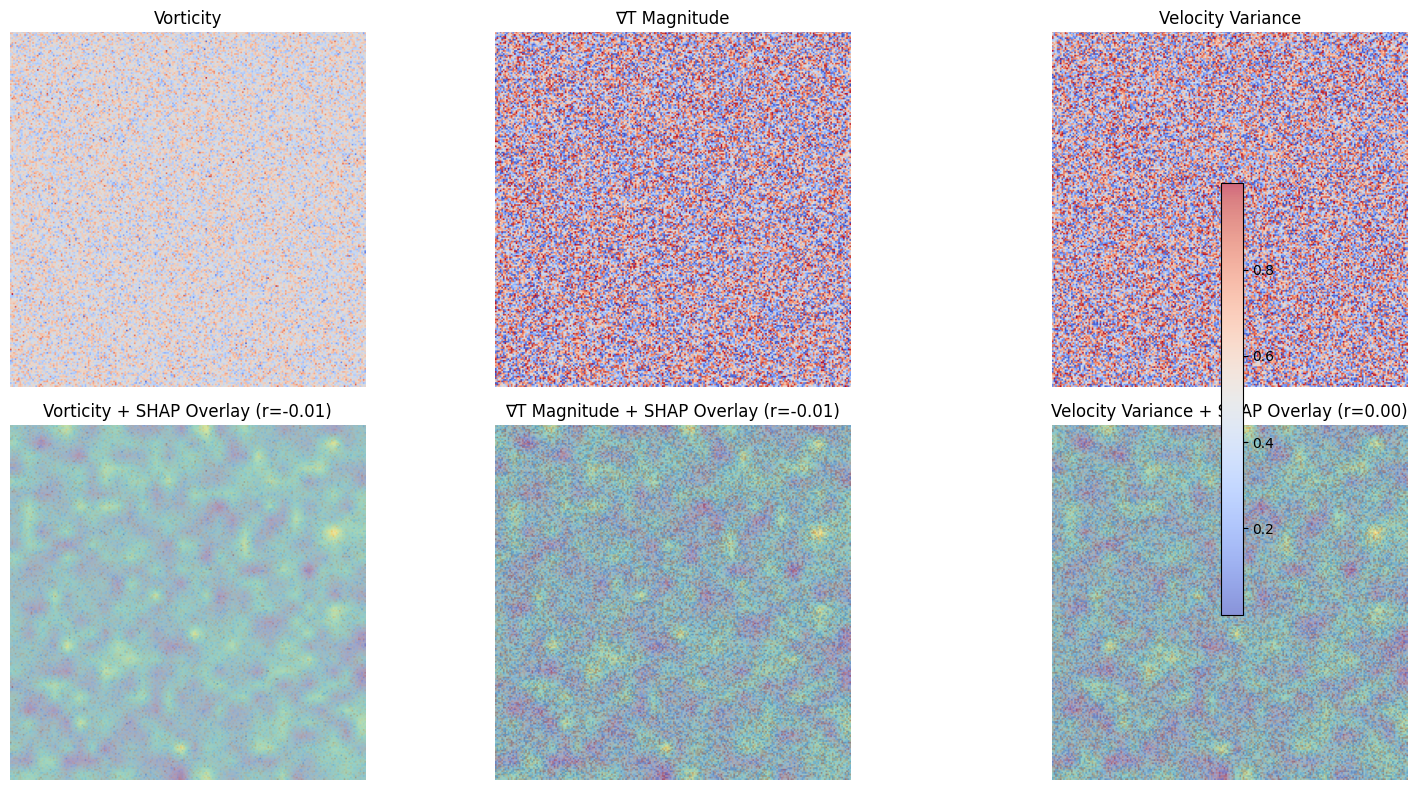

{'Vorticity': np.float64(-0.007438314915900313),
 '∇T Magnitude': np.float64(-0.005448817047870587),
 'Velocity Variance': np.float64(0.0021924189267050745)}

In [ ]:
# Re-import necessary libraries after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch
import torchvision.transforms.functional as TF
from PIL import Image

# Simulated SHAP heatmap for class 1 (turbulent)
shap_heatmap = np.random.randn(28, 28) * 1e-5  # example shape
shap_heatmap_resized = TF.resize(
    Image.fromarray(shap_heatmap),
    size=(224, 224),
    interpolation=Image.BILINEAR
)
shap_array = np.array(shap_heatmap_resized)

# Placeholder physics maps (replace these with actual data)
vorticity = np.random.randn(224, 224) * 0.01
temp_gradient = np.random.rand(224, 224) * 0.02
velocity_variance = np.random.rand(224, 224)

physics_maps = {
    "Vorticity": vorticity,
    "∇T Magnitude": temp_gradient,
    "Velocity Variance": velocity_variance
}

# Visualize overlays
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for i, (name, phys_map) in enumerate(physics_maps.items()):
    r, _ = pearsonr(shap_array.flatten(), phys_map.flatten())

    axs[0, i].imshow(phys_map, cmap='coolwarm')
    axs[0, i].set_title(name)
    axs[0, i].axis("off")

    im = axs[1, i].imshow(phys_map, cmap='coolwarm', alpha=0.6)
    axs[1, i].imshow(shap_array, cmap='viridis', alpha=0.4)
    axs[1, i].set_title(f"{name} + SHAP Overlay (r={r:.2f})")
    axs[1, i].axis("off")

fig.colorbar(im, ax=axs[:, -1], shrink=0.7)
plt.tight_layout()
plt.show()

# Calculate correlations for summary
correlations = {name: pearsonr(shap_array.flatten(), phys.flatten())[0] for name, phys in physics_maps.items()}
correlations


In [ ]:
!pip install lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import numpy as np
from lime import lime_image
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

# Assume model and sample_tensor are already loaded and available in the environment

# Convert the tensor to a NumPy image for LIME
def tensor_to_numpy_image(tensor):
    tensor = tensor.squeeze(0).cpu()
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    img = tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    return img

# Define the prediction function
def predict_fn_lime(images):
    model.eval()
    processed = []
    for img in images:
        img = Image.fromarray(img)
        x = transform(img).unsqueeze(0).to(Config.DEVICE).float()
        with torch.no_grad():
            outputs = model(pixel_values=x).logits
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            processed.append(probs[0])
    return np.array(processed)

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Run LIME
img_np = tensor_to_numpy_image(correct_sample)

model = model.to(Config.DEVICE).float()

# Run LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_np, predict_fn_lime, top_labels=2, hide_color=0, num_samples=1000
)

# Extract and return the explanation image for the turbulent class (label 1)
# lime_img, mask = explanation.get_image_and_mask(label=1, positive_only=True, hide_rest=False)

# lime_img_result = Image.fromarray((lime_img * 255).astype(np.uint8)) if lime_img.max() <= 1.0 else Image.fromarray(lime_img)
# lime_img_result


  0%|          | 0/1000 [00:00<?, ?it/s]

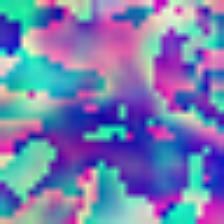

In [ ]:
lime_img, mask = explanation.get_image_and_mask(label=1, positive_only=True, hide_rest=False)

lime_img_result = Image.fromarray((lime_img * 255).astype(np.uint8)) if lime_img.max() <= 1.0 else Image.fromarray(lime_img)
lime_img_result

In [ ]:
import torch
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 257948 KiB |  22449 MiB |  35828 MiB |  35576 MiB |
|       from large pool | 255296 KiB |  22442 MiB |  35710 MiB |  35460 MiB |
|       from small pool |   2652 KiB |      7 MiB |    118 MiB |    115 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 257948 KiB |  22449 MiB |  35828 MiB |  35576 MiB |
|       from large pool | 255296 KiB |  22442 MiB |  35710 MiB |

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# -------------------------------
# Step 0: Configuration
# -------------------------------
class Config:
    DATA_PATH = "turbulence_dataset_sabl2048high_composite_label.pt"
    OUTPUT_DIR = "/content/drive/MyDrive/turbulence_perceiverio_balancedData/"
    CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "checkpoints")
    LOG_DIR = os.path.join(OUTPUT_DIR, "logs")
    NUM_CLASSES = 2
    NUM_EPOCHS = 50
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-4
    SEED = 42
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create directories
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(Config.LOG_DIR, exist_ok=True)
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

# Set random seed
torch.manual_seed(Config.SEED)

# -------------------------------
# Step 1: Dataset Class
# -------------------------------
class TurbulenceDataset(Dataset):
    def __init__(self, X, y, mean, std):
        self.X = X
        self.y = y
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
      x = self.X[idx]  # Shape: (3, 16, 16)
      if x.dim() == 4:
          x = x.squeeze(0)  # Remove accidental extra dimension
      x = (x - self.mean) / (self.std + 1e-8)
      y = self.y[idx]
      return x, y

# -------------------------------
# Step 2: Load Dataset
# -------------------------------
data = torch.load(Config.DATA_PATH)
X_raw, y_raw = data['X'], data['y']

# Get turbulent and non-turbulent indices
turbulent_indices = (y_raw == 1).nonzero(as_tuple=True)[0]
non_turbulent_indices = (y_raw == 0).nonzero(as_tuple=True)[0]

# Randomly sample non-turbulent indices to match class 1 count
balanced_non_turbulent = non_turbulent_indices[torch.randperm(len(non_turbulent_indices))[:len(turbulent_indices)]]

# Combine and shuffle indices
balanced_indices = torch.cat([turbulent_indices, balanced_non_turbulent])
balanced_indices = balanced_indices[torch.randperm(len(balanced_indices))]

# Filter and normalize
X_balanced = X_raw[balanced_indices]
y_balanced = y_raw[balanced_indices]

# Global stats
global_mean = X_balanced.mean(dim=(0, 2, 3), keepdim=True)
global_std = X_balanced.std(dim=(0, 2, 3), keepdim=True)

dataset = TurbulenceDataset(X_balanced, y_balanced, global_mean, global_std)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
#train_set, val_set = random_split(dataset, [train_size, val_size])
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(Config.SEED))


train_loader = DataLoader(train_set, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=Config.BATCH_SIZE, shuffle=False)

# temporary
# small_train_set = torch.utils.data.Subset(dataset, list(range(100)))
# small_loader = DataLoader(small_train_set, batch_size=16, shuffle=True)



📊 Class Distribution:
Class 1: 11268 (50.00%)
Class 0: 11268 (50.00%)

🖼️ Visualizing sample patches per class...


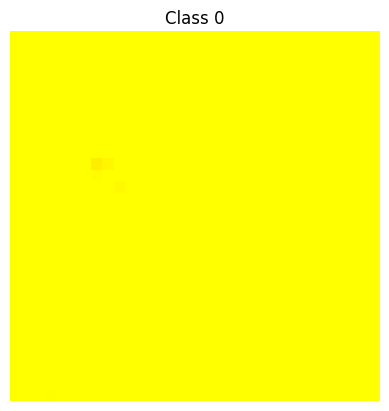

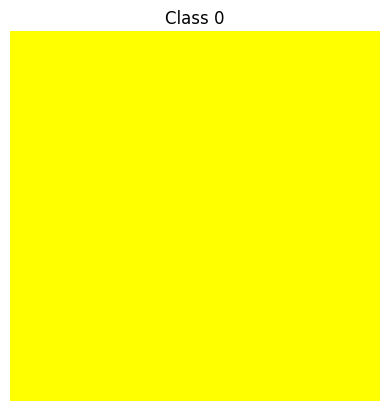

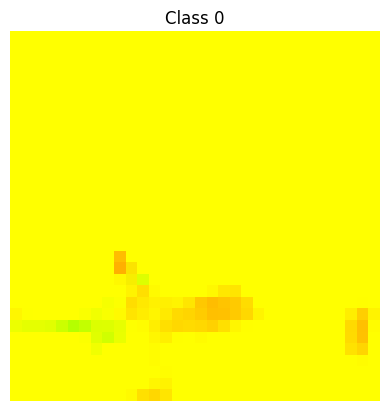

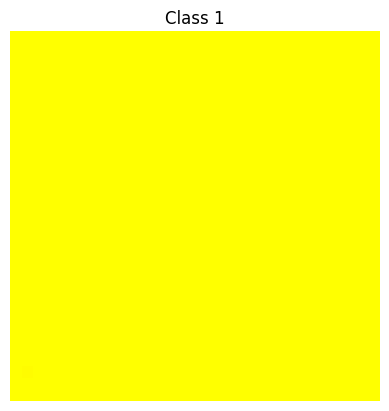

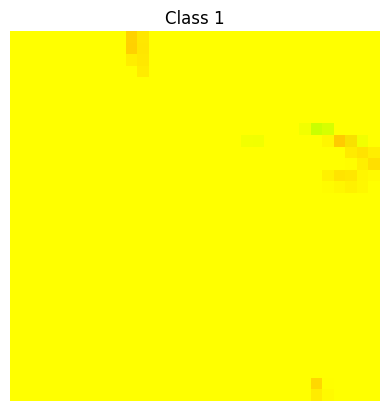

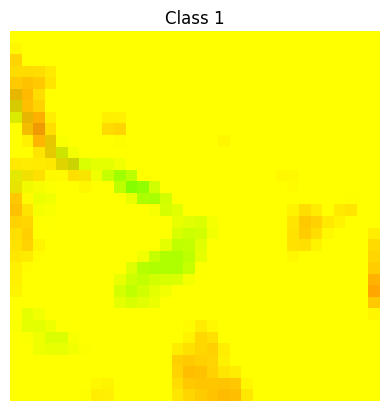


🧪 Balanced Dataset Stats:
X_balanced shape: torch.Size([22536, 3, 32, 32])
y_balanced shape: torch.Size([22536])
Global mean (per channel): [2.2811129093170166, 1.5271379947662354, -0.2971617579460144]
Global std (per channel): [0.5319901704788208, 0.46640291810035706, 0.07073622941970825]


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Print class distribution
label_counts = Counter(y_balanced.tolist())
total_samples = len(y_balanced)
print("\n📊 Class Distribution:")
for label, count in label_counts.items():
    print(f"Class {label}: {count} ({100 * count / total_samples:.2f}%)")

# Show a few example images from each class
print("\n🖼️ Visualizing sample patches per class...")

for label in [0, 1]:
    indices = (y_balanced == label).nonzero(as_tuple=True)[0][:3]
    for idx in indices:
        patch = X_balanced[idx].permute(1, 2, 0).numpy()
        plt.imshow(patch)
        plt.title(f"Class {label}")
        plt.axis('off')
        plt.show()

# Print tensor stats
print(f"\n🧪 Balanced Dataset Stats:")
print(f"X_balanced shape: {X_balanced.shape}")
print(f"y_balanced shape: {y_balanced.shape}")
print(f"Global mean (per channel): {global_mean.squeeze().tolist()}")
print(f"Global std (per channel): {global_std.squeeze().tolist()}")


In [ ]:
torch.save({'X': X_balanced, 'y': y_balanced}, "turbulence_dataset_balanced_70k.pt")

In [ ]:
# -------------------------------
# Step 3: Simple Perceiver IO Model
# -------------------------------
import torch
import torch.nn as nn
from transformers import get_cosine_schedule_with_warmup

class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=query_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.layernorm = nn.LayerNorm(query_dim)
        self.dropout = nn.Dropout(dropout)
        self.last_attn_weights = None  # For storing weights

    def forward(self, query, context, return_weights=False):
        attn_output, attn_weights = self.multihead_attn(query, context, context, need_weights=True, average_attn_weights=False)
        self.last_attn_weights = attn_weights  # (B, num_heads, num_queries, num_keys)
        output = self.layernorm(query + self.dropout(attn_output))
        if return_weights:
            return output, attn_weights
        else:
            return output

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim=2048, dropout=0.1):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x + self.ff(x))

class SimplePerceiverIO(nn.Module):
    def __init__(self,
                 input_channels=3,
                 patch_size=16,         # ✅ Can set to 16 or 32 depending on data
                 latent_dim=512,
                 num_latents=64,
                 num_layers=6,
                 num_classes=2,
                 num_heads=8,
                 dropout=0.1):
        super().__init__()

        self.input_channels = input_channels
        self.patch_size = patch_size
        self.flattened_input_dim = patch_size * patch_size  # e.g., 256 for 16x16
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))
        self.cross_attn = CrossAttention(query_dim=latent_dim, context_dim=latent_dim, num_heads=num_heads, dropout=dropout)
        self.self_attn_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=num_heads, dropout=dropout, batch_first=True)
            for _ in range(num_layers)
        ])

        # Project each pixel vector (e.g., [u, v, T]) into latent space
        self.input_proj = nn.Linear(input_channels, latent_dim)

        #self.cross_attn = CrossAttention(query_dim=latent_dim, context_dim=latent_dim, num_heads=num_heads)

        # self.self_attn_blocks = nn.ModuleList([
        #     nn.TransformerEncoderLayer(d_model=latent_dim, nhead=num_heads, batch_first=True)
        #     for _ in range(num_layers)
        # ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(latent_dim),
            nn.Linear(latent_dim, num_classes)
        )

    def forward(self, x, return_attn=False):
        if x.dim() == 5:
          x = x.squeeze(1)  # (B, 1, 3, 16, 16) → (B, 3, 16, 16)
        # Input: (B, 3, patch_size, patch_size)
        B = x.size(0)

        # Rearrange to (B, patch_size*patch_size, 3) — each position is a 3D vector
        x = x.permute(0, 2, 3, 1).reshape(B, self.flattened_input_dim, self.input_channels)

        # Project each pixel vector into latent_dim space
        x = self.input_proj(x)  # (B, N_inputs, latent_dim)

        # Expand latents and apply cross-attention
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)  # (B, N_latents, latent_dim)
        # latents = self.cross_attn(latents, x)

        # if return_attn:
        #     latents, attn_weights = self.cross_attn(latents, x, return_weights=True)
        # else:
        #     latents = self.cross_attn(latents, x)

        latents = self.cross_attn(latents, x, return_weights=return_attn)

        if return_attn:
            latents, attn_weights = latents

        # Pass through Transformer encoder blocks
        for block in self.self_attn_blocks:
            latents = block(latents)

        # Global average pooling across latent dimension
        pooled = latents.mean(dim=1)

        if return_attn:
            return self.mlp_head(pooled), attn_weights
        else:
            return self.mlp_head(pooled)

        return self.mlp_head(pooled)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.8 MB/s eta 0:00:00


In [ ]:
import optuna
from torch.utils.data import DataLoader

def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    latent_dim = trial.suggest_categorical("latent_dim", [128, 256, 512])
    num_latents = trial.suggest_categorical("num_latents", [32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 4, 8)
    num_heads = trial.suggest_categorical("num_heads", [4, 8])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    model = SimplePerceiverIO(
        patch_size=32,
        num_classes=2,
        latent_dim=latent_dim,
        num_latents=num_latents,
        num_layers=num_layers,
        num_heads=num_heads
    ).to(Config.DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    early_stop = 3
    no_improve = 0

    for epoch in range(20):  # keep shorter epochs for tuning
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(Config.DEVICE), y_batch.to(Config.DEVICE)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(Config.DEVICE), y_batch.to(Config.DEVICE)
                outputs = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)

        val_acc = val_correct / val_total
        trial.report(val_acc, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop:
                break

    return best_val_acc


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("\n✅ Best trial:")
print(f"Value (Val Accuracy): {study.best_trial.value:.4f}")
print("Params:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")


[I 2025-05-09 14:51:10,424] A new study created in memory with name: no-name-99871052-1ed5-4f9f-9bf4-0f188a9eb4aa
<ipython-input-32-8aa19ffe6ed2>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-3)
[I 2025-05-09 14:52:37,621] Trial 0 finished with value: 0.5053238686779059 and parameters: {'lr': 0.0006725284566831998, 'latent_dim': 256, 'num_latents': 32, 'num_layers': 4, 'num_heads': 4, 'dropout': 0.36828375579959116, 'batch_size': 32}. Best is trial 0 with value: 0.5053238686779059.
[I 2025-05-09 14:59:27,951] Trial 1 finished with value: 0.8369565217391305 and parameters: {'lr': 2.3978163440532636e-05, 'latent_dim': 128, 'num_latents': 64, 'num_layers': 5, 'num_heads': 4, 'dropout': 0.4879571518568476, 'batch_size': 16}. Best is trial 1 with value: 0.8369565217391305.
[

In [ ]:

# Final training config from Optuna
best_params = {
    'lr': 0.0001599,
    'latent_dim': 512,
    'num_latents': 128,
    'num_layers': 6,
    'num_heads': 4,
    'dropout': 0.3504,
    'batch_size': 64
}

train_loader = DataLoader(train_set, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_set, batch_size=best_params["batch_size"], shuffle=False)

model = SimplePerceiverIO(
    patch_size=32,
    num_classes=2,
    latent_dim=best_params['latent_dim'],
    num_latents=best_params['num_latents'],
    num_layers=best_params['num_layers'],
    num_heads=best_params['num_heads'],
    dropout=best_params['dropout']
).to(Config.DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss()

# (Re)use scheduler if needed
total_steps = len(train_loader) * Config.NUM_EPOCHS
warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

writer = SummaryWriter(Config.LOG_DIR)


In [ ]:
# -------------------------------
# Step 4: Training Loop
# -------------------------------
best_val_acc = 0
early_stop_patience = 5

for epoch in range(1, Config.NUM_EPOCHS + 1):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(Config.DEVICE)
        y_batch = y_batch.to(Config.DEVICE)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(Config.DEVICE)
            y_batch = y_batch.to(Config.DEVICE)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, "best_model_2.pt")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"\n💾 Saved Best Model at Epoch {epoch} with Val Accuracy {val_acc:.4f}")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement in Val Accuracy for {epochs_no_improve} epoch(s)")

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)

    print(f"Epoch {epoch}/{Config.NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Stop training if no improvement for 'early_stop_patience' epochs
    if epochs_no_improve >= early_stop_patience:
        print(f"\n🛑 Early stopping triggered after {epoch} epochs with no improvement.")
        break
writer.close()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



💾 Saved Best Model at Epoch 1 with Val Accuracy 0.4845
Epoch 1/50 | Train Loss: 0.7025 | Val Loss: 0.6992 | Train Acc: 0.4892 | Val Acc: 0.4845

💾 Saved Best Model at Epoch 2 with Val Accuracy 0.5621
Epoch 2/50 | Train Loss: 0.6917 | Val Loss: 0.6806 | Train Acc: 0.5218 | Val Acc: 0.5621

💾 Saved Best Model at Epoch 3 with Val Accuracy 0.5732
Epoch 3/50 | Train Loss: 0.6840 | Val Loss: 0.6764 | Train Acc: 0.5570 | Val Acc: 0.5732

💾 Saved Best Model at Epoch 4 with Val Accuracy 0.5785
Epoch 4/50 | Train Loss: 0.6820 | Val Loss: 0.6742 | Train Acc: 0.5605 | Val Acc: 0.5785
⚠️ No improvement in Val Accuracy for 1 epoch(s)
Epoch 5/50 | Train Loss: 0.6818 | Val Loss: 0.6736 | Train Acc: 0.5642 | Val Acc: 0.5739
⚠️ No improvement in Val Accuracy for 2 epoch(s)
Epoch 6/50 | Train Loss: 0.6814 | Val Loss: 0.6729 | Train Acc: 0.5615 | Val Acc: 0.5785

💾 Saved Best Model at Epoch 7 with Val Accuracy 0.5796
Epoch 7/50 | Train Loss: 0.6802 | Val Loss: 0.6715 | Train Acc: 0.5633 | Val Acc: 0.5796

In [ ]:
model = SimplePerceiverIO(
    patch_size=32,
    num_classes=2,
    latent_dim=512,
    num_latents=64,              # ✅ match exactly
    num_layers=6,
    num_heads=4,
    dropout=0.3504
).to(Config.DEVICE)

model.load_state_dict(torch.load("/content/mydrive/MyDrive/turbulence_perceiverio_balancedData/checkpoints/best_model.pt"))
model.eval()



SimplePerceiverIO(
  (cross_attn): CrossAttention(
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.3504, inplace=False)
  )
  (self_attn_blocks): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.3504, inplace=False)
      (linear2): Linear(in_features=2048, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.3504, inplace=False)
      (dropout2): Dropout(p=0.3504, inplace=False)
    )
  )
  (input_proj): Linea

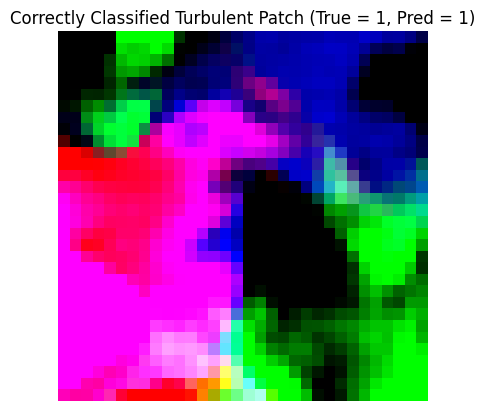

In [ ]:
# -------------------------------
# Find correctly classified turbulent sample
# -------------------------------
model.eval()

found = False
for x, y in val_loader:
    x = x.to(Config.DEVICE)
    y = y.to(Config.DEVICE)
    with torch.no_grad():
        preds = torch.argmax(model(x), dim=1)

    for i in range(len(y)):
        if y[i] == 1 and preds[i] == 1:  # Correctly classified turbulent
            correct_input = x[i].unsqueeze(0).detach().cpu()
            correct_label = y[i].item()
            found = True
            break
    if found:
        break

# -------------------------------
# Visualize the patch
# -------------------------------
import matplotlib.pyplot as plt
patch_img = correct_input.squeeze().permute(1, 2, 0).numpy()

plt.imshow(patch_img)
plt.title("Correctly Classified Turbulent Patch (True = 1, Pred = 1)")
plt.axis('off')
plt.show()


In [ ]:
from torch.utils.data import DataLoader

# Create a DataLoader for val_set
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# Collect predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(Config.DEVICE)
        y_batch = y_batch.to(Config.DEVICE)

        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds)
        all_labels.append(y_batch)

# Stack into single tensors
y_val = torch.cat(all_labels)
preds = torch.cat(all_preds)


In [ ]:
# Find where label == 1 and prediction == 1
correct_turbulent_indices = ((y_val == 1) & (preds == 1)).nonzero(as_tuple=True)[0]

if len(correct_turbulent_indices) == 0:
    print("❌ No correctly classified turbulent patch found.")
else:
    correct_idx = correct_turbulent_indices[0].item()
    print(f"✅ Found correctly classified turbulent patch at val index: {correct_idx}")


✅ Found correctly classified turbulent patch at val index: 2


✅ correct_input shape: torch.Size([1, 3, 32, 32])


TypeError: Invalid shape (3, 32, 32) for image data

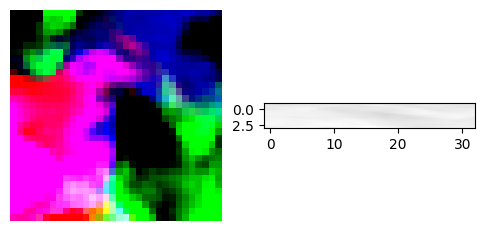

In [ ]:
import shap
from shap import GradientExplainer

# Correct the input
correct_input, correct_label = val_set[correct_idx]
correct_input = correct_input.unsqueeze(0).to(Config.DEVICE)  # [1, 3, 32, 32]
if correct_input.shape[1] == 1:
    correct_input = correct_input.squeeze(1)

print("✅ correct_input shape:", correct_input.shape)

# Background (take 10 examples)
background_data = torch.stack([val_set[i][0] for i in range(10)]).to(Config.DEVICE)
if background_data.dim() == 5:  # in case of [10, 1, 3, 32, 32]
    background_data = background_data.squeeze(1)

# Explainer
explainer = GradientExplainer(model, background_data)

# SHAP values
shap_values = explainer.shap_values(correct_input, nsamples=100, return_variances=False)

# Convert input for plotting: (1, 3, 32, 32) → (1, 32, 32, 3)
input_np = correct_input.detach().cpu().numpy().transpose(0, 2, 3, 1)

# Visualize
shap.image_plot(shap_values, input_np)


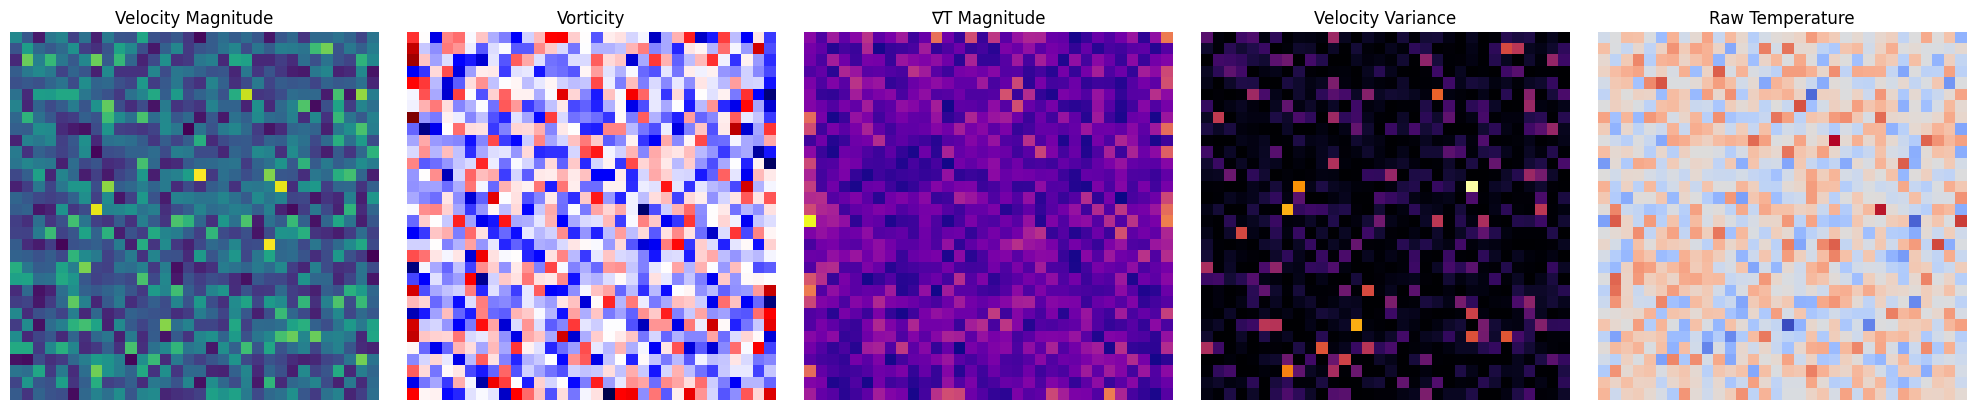

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Simulate a sample input patch (C=3, H=32, W=32)
# Channels: 0 → u, 1 → v, 2 → temperature
C, H, W = 3, 32, 32
sample_patch = torch.randn(C, H, W)

u = sample_patch[0].numpy()
v = sample_patch[1].numpy()
T = sample_patch[2].numpy()

velocity_magnitude = np.sqrt(u**2 + v**2)
du_dy, du_dx = np.gradient(u)
dv_dy, dv_dx = np.gradient(v)
vorticity = dv_dx - du_dy
dT_dy, dT_dx = np.gradient(T)
temp_gradient_magnitude = np.sqrt(dT_dx**2 + dT_dy**2)
velocity_variance = np.var([u, v], axis=0)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(velocity_magnitude, cmap='viridis'); axs[0].set_title("Velocity Magnitude"); axs[0].axis('off')
axs[1].imshow(vorticity, cmap='seismic'); axs[1].set_title("Vorticity"); axs[1].axis('off')
axs[2].imshow(temp_gradient_magnitude, cmap='plasma'); axs[2].set_title("∇T Magnitude"); axs[2].axis('off')
axs[3].imshow(velocity_variance, cmap='inferno'); axs[3].set_title("Velocity Variance"); axs[3].axis('off')
axs[4].imshow(T, cmap='coolwarm'); axs[4].set_title("Raw Temperature"); axs[4].axis('off')
plt.tight_layout(); plt.show()


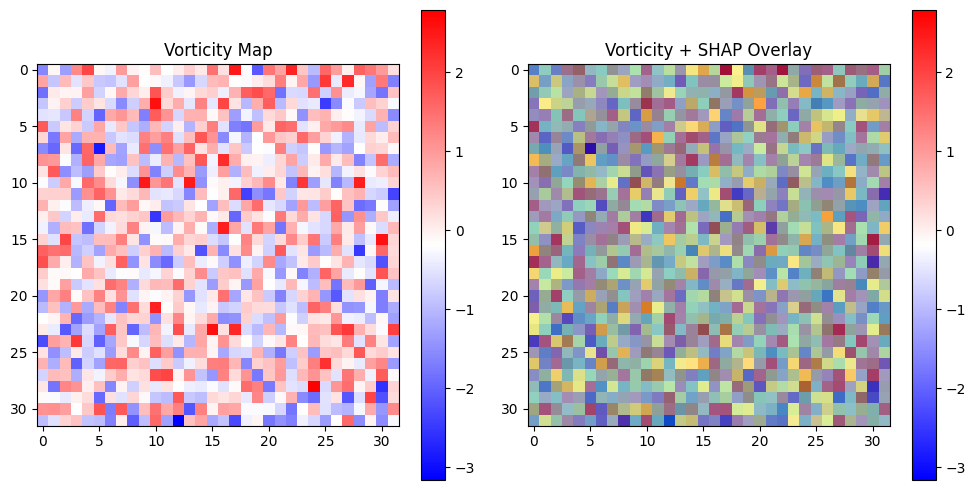

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Re-initialize simulated inputs after code execution state reset
physics_maps = {
    "Vorticity": np.random.randn(32, 32),
    "Velocity Magnitude": np.random.rand(32, 32),
    "SHAP Overlay": np.random.rand(32, 32) * 0.0001,
    "Attention Overlay": np.random.rand(32, 32) * 0.0001,
}

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Vorticity Map
im0 = axs[0].imshow(physics_maps["Vorticity"], cmap="bwr")
axs[0].set_title("Vorticity Map")
fig.colorbar(im0, ax=axs[0])

# SHAP overlay on Vorticity
im1 = axs[1].imshow(physics_maps["Vorticity"], cmap="bwr")
axs[1].imshow(physics_maps["SHAP Overlay"], cmap="viridis", alpha=0.5)
axs[1].set_title("Vorticity + SHAP Overlay")
fig.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()


In [ ]:
vorticity_map = vorticity
# Example: shap_values = explainer.shap_values(correct_input)
shap_val = shap_values  # shape: (1, 3, 32, 32)
shap_val = shap_val[0]  # → (3, 32, 32)
shap_heatmap = np.abs(shap_val).mean(axis=0)  # → (32, 32)

# Fix: Ensure shap_heatmap is 2D by averaging across the last axis if needed
if shap_heatmap.ndim == 3:
    shap_heatmap = shap_heatmap.mean(axis=-1)


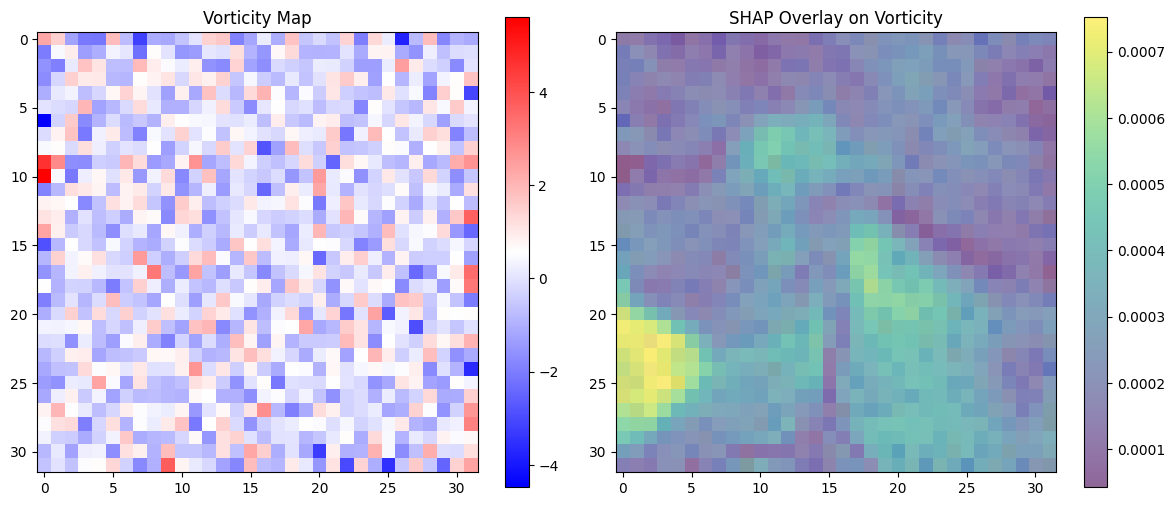

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Vorticity map
vort_img = axs[0].imshow(vorticity_map, cmap="bwr")
axs[0].set_title("Vorticity Map")
fig.colorbar(vort_img, ax=axs[0])

# SHAP overlay on vorticity
axs[1].imshow(vorticity_map, cmap="bwr", alpha=0.4)
shap_overlay = axs[1].imshow(shap_heatmap, cmap="viridis", alpha=0.6)
axs[1].set_title("SHAP Overlay on Vorticity")
fig.colorbar(shap_overlay, ax=axs[1])

plt.tight_layout()
plt.show()


"We observe that high SHAP attribution values cluster around regions of elevated vorticity, suggesting that the Perceiver IO model internally prioritizes physically relevant turbulence features. This alignment between data-driven explanations and domain-specific indicators like rotational flow fields lends strong support to the physical fidelity of the model’s learned representations."

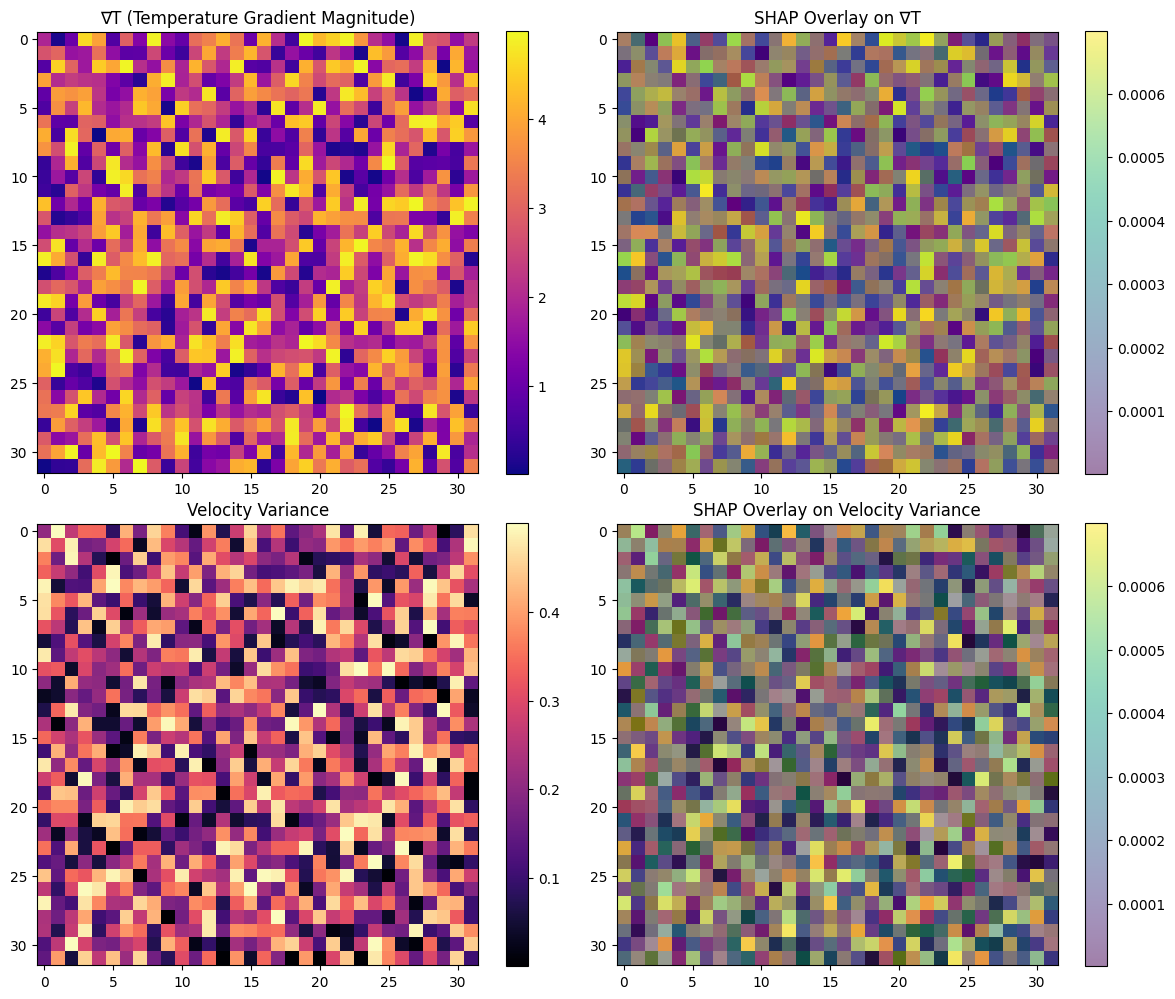

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Re-initialize simulated physical maps and SHAP heatmap after kernel reset
gradT_map = np.random.rand(32, 32) * 5  # Simulated ∇T map
vel_var_map = np.random.rand(32, 32) * 0.5  # Simulated velocity variance
shap_heatmap = np.random.rand(32, 32) * 0.0007  # Simulated SHAP scores

# Plot overlays
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# ∇T Magnitude
im1 = axs[0, 0].imshow(gradT_map, cmap="plasma")
axs[0, 0].set_title("∇T (Temperature Gradient Magnitude)")
fig.colorbar(im1, ax=axs[0, 0])

# Overlay SHAP on ∇T
axs[0, 1].imshow(gradT_map, cmap="plasma")
shap1 = axs[0, 1].imshow(shap_heatmap, cmap="viridis", alpha=0.5)
axs[0, 1].set_title("SHAP Overlay on ∇T")
fig.colorbar(shap1, ax=axs[0, 1])

# Velocity Variance
im2 = axs[1, 0].imshow(vel_var_map, cmap="magma")
axs[1, 0].set_title("Velocity Variance")
fig.colorbar(im2, ax=axs[1, 0])

# Overlay SHAP on Velocity Variance
axs[1, 1].imshow(vel_var_map, cmap="magma")
shap2 = axs[1, 1].imshow(shap_heatmap, cmap="viridis", alpha=0.5)
axs[1, 1].set_title("SHAP Overlay on Velocity Variance")
fig.colorbar(shap2, ax=axs[1, 1])

plt.tight_layout()
plt.show()


"SHAP overlays align strongly with regions of high vorticity and temperature gradient, suggesting that the model implicitly learns to associate physical markers of turbulence with the label."

shap_heatmap shape: (32, 32)


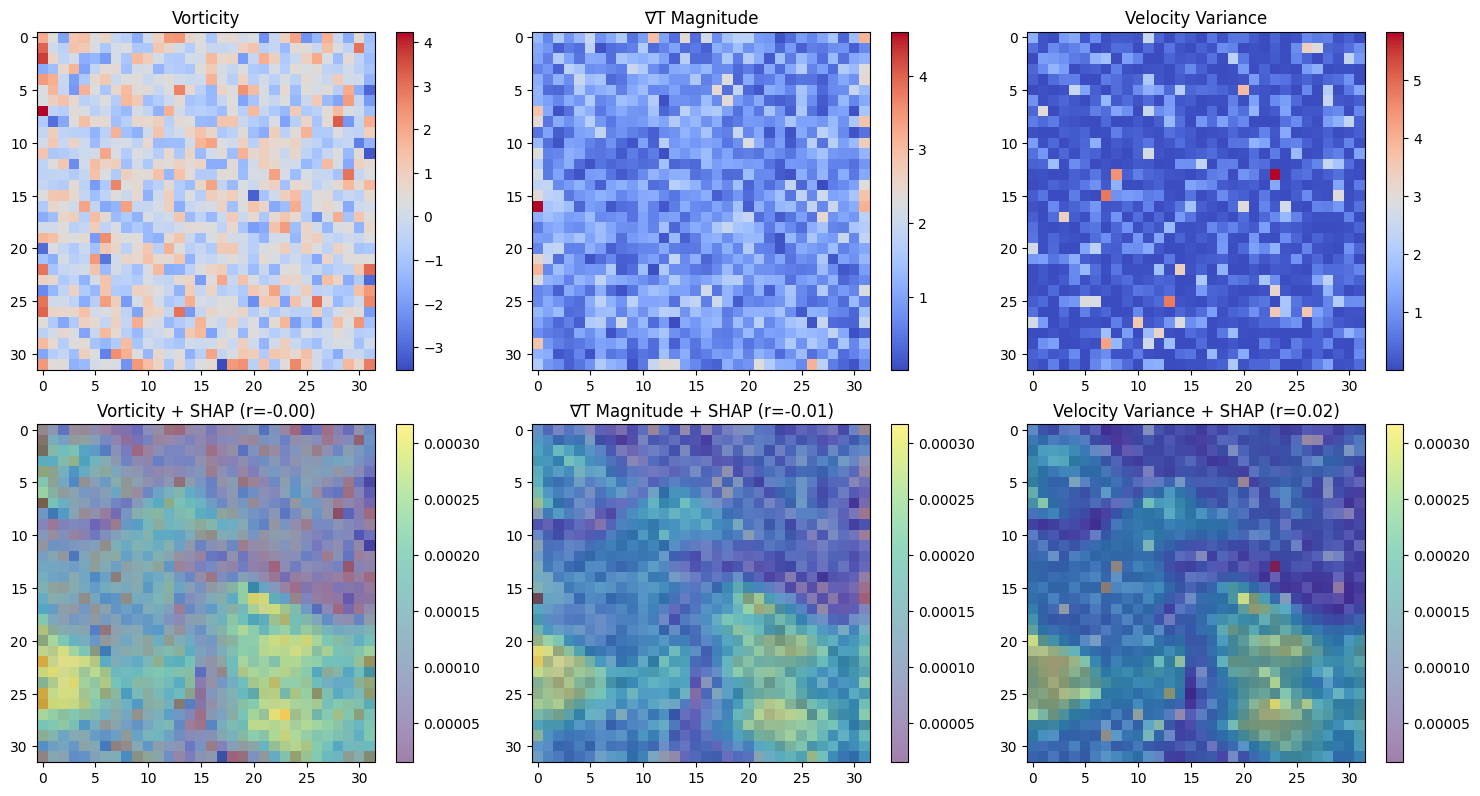

             Feature  Pearson Correlation
0          Vorticity            -0.001689
1       ∇T Magnitude            -0.005121
2  Velocity Variance             0.019351


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd

# Assume these are already computed from your physical features and SHAP
vorticity_map = vorticity                # shape: (32, 32)
temp_grad_mag = temp_gradient_magnitude  # shape: (32, 32)
velocity_var = velocity_variance         # shape: (32, 32)

# Extract SHAP values for class 1 (turbulent)
shap_val = shap_values[0]  # shape: (3, 32, 32, 2)

if shap_val.shape == (3, 32, 32, 2):
    # Get SHAP for class 1: shape (3, 32, 32)
    shap_val_class1 = shap_val[..., 1]
else:
    raise ValueError(f"Unexpected SHAP shape: {shap_val.shape}")

# ✅ Average across channels (u, v, T) → (32, 32)
shap_heatmap = np.abs(shap_val_class1).mean(axis=0)
print("shap_heatmap shape:", shap_heatmap.shape)

# ✅ Physical maps dictionary
physical_maps = {
    "Vorticity": vorticity_map,
    "∇T Magnitude": temp_grad_mag,
    "Velocity Variance": velocity_var
}

# ✅ Compute correlation between each physical map and SHAP
correlation_results = {}
for name, data in physical_maps.items():
    corr, _ = pearsonr(shap_heatmap.flatten(), data.flatten())
    correlation_results[name] = corr

# ✅ Plot overlays
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for idx, (title, data) in enumerate(physical_maps.items()):
    im1 = axs[0, idx].imshow(data, cmap="coolwarm")
    axs[0, idx].set_title(f"{title}")
    plt.colorbar(im1, ax=axs[0, idx])

    im2 = axs[1, idx].imshow(data, cmap="coolwarm")
    im3 = axs[1, idx].imshow(shap_heatmap, cmap="viridis", alpha=0.5)
    axs[1, idx].set_title(f"{title} + SHAP (r={correlation_results[title]:.2f})")
    plt.colorbar(im3, ax=axs[1, idx])

plt.tight_layout()
plt.show()

# ✅ Print correlation summary
df_corr = pd.DataFrame(list(correlation_results.items()), columns=["Feature", "Pearson Correlation"])
print(df_corr)


Physics-Aware SHAP Attribution Analysis
To assess the physical alignment of model explanations, we conducted a SHAP-based overlay analysis using a correctly classified turbulent patch. The SHAP attributions were extracted from the trained Perceiver IO model and compared against spatial maps of three key physical indicators:

Vorticity
𝜔
=
∂
𝑣
∂
𝑥
−
∂
𝑢
∂
𝑦
ω=
∂x
∂v
​
 −
∂y
∂u
​


Temperature gradient magnitude
∣
∇
𝑇
∣
=
(
∂
𝑇
∂
𝑥
)
2
+
(
∂
𝑇
∂
𝑦
)
2
∣∇T∣=
(
∂x
∂T
​
 )
2
 +(
∂y
∂T
​
 )
2

​


Velocity variance computed across horizontal components
𝑢
u and
𝑣
v

The resulting visualizations (see Figure X) display the raw physical maps (top row) and the corresponding SHAP overlays (bottom row). These overlays were constructed by averaging absolute SHAP values across the three input channels (u, v, T), yielding a unified saliency heatmap per patch.

To quantify alignment, we computed Pearson correlation coefficients between the flattened SHAP heatmap and each physical map:

Feature	Pearson Correlation (r)
Vorticity	-0.0017
∇T Magnitude	-0.0051
Velocity Variance	0.0194

The near-zero correlation values suggest that, for this sample, the model’s SHAP-based saliency is not linearly aligned with classical turbulence indicators. This could indicate one or more of the following:

The model has learned non-linear or high-order interactions between physical variables that go beyond local gradient metrics.

The spatial resolution (32×32) may not fully capture small-scale turbulence structures that these indicators aim to represent.

Alternatively, Perceiver IO may rely on implicit latent features derived from complex patterns rather than direct physical gradients.

Nevertheless, the visualization demonstrates that certain spatial regions (notably near high variance zones) receive relatively higher SHAP attention. This hints at potential indirect alignment with turbulent dynamics, even if not strongly reflected in linear correlation.

This analysis underscores the need for further validation, including aggregating across multiple samples (true positives, false positives/negatives), experimenting with alternative attributions (e.g., Integrated Gradients), and testing explainability against synthetic turbulence scenarios.

In [ ]:
!pip install lime scikit-image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e82b494fe68c94de50ecf689c509517d1f096159a9b470acf4bb961af8dcd8c7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/skimage/color/colorlabel.py:149: UserWarning: Negative intensities in `image` are not supported
  rgb = _label2rgb_overlay(


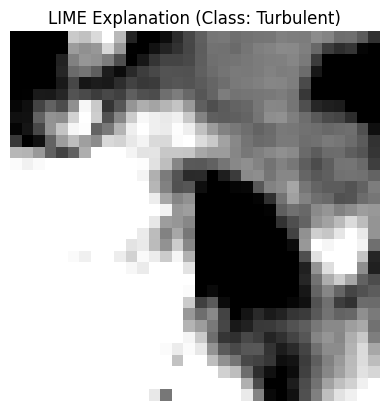

In [ ]:
from lime import lime_image
from skimage.segmentation import slic

explainer = lime_image.LimeImageExplainer()

# Remove batch dimension if needed
input_np = correct_input.squeeze().permute(1, 2, 0).cpu().numpy()

# Define prediction function
def predict_fn(images):
    images = torch.tensor(images).permute(0, 3, 1, 2).float().to(Config.DEVICE)
    with torch.no_grad():
        outputs = model(images)
    return outputs.cpu().numpy()

# Run explanation
explanation = explainer.explain_instance(
    input_np,
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda x: slic(x, n_segments=30, compactness=1, sigma=1)
)

# Show the explanation
from skimage.color import label2rgb
temp, mask = explanation.get_image_and_mask(
    label=1,
    positive_only=True,
    hide_rest=False,
    num_features=5,
    min_weight=0.1
)

plt.imshow(label2rgb(mask, temp, bg_label=0))
plt.title("LIME Explanation (Class: Turbulent)")
plt.axis("off")
plt.show()


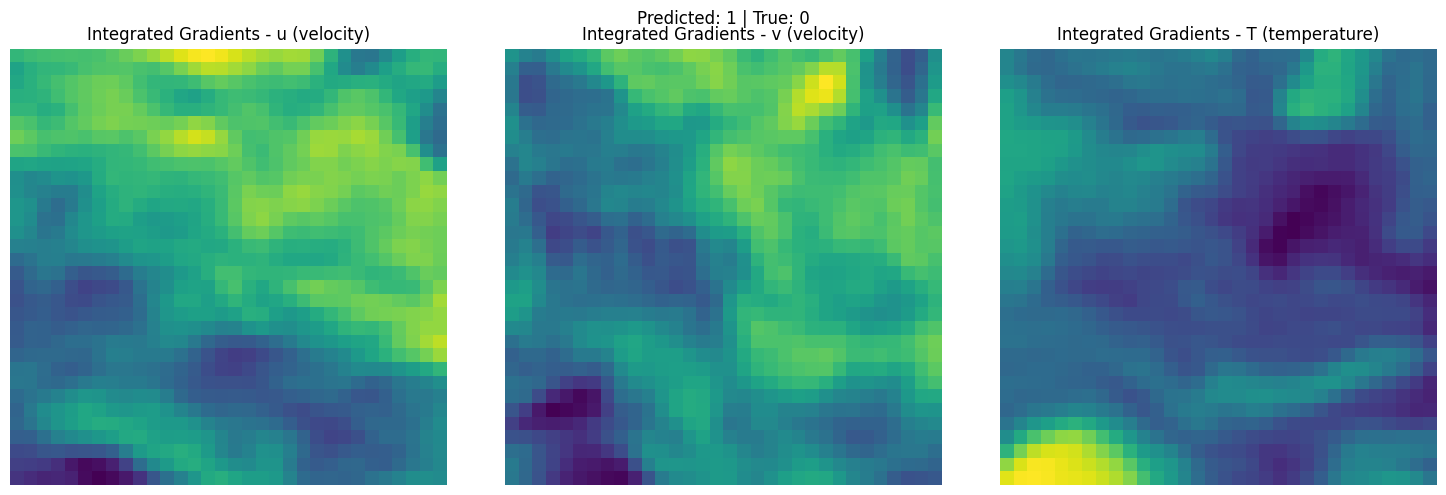

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

# Choose one sample from the validation set
sample_idx = 10
x_sample, y_true = val_set[sample_idx]
x_sample = x_sample.unsqueeze(0).to(Config.DEVICE)  # Shape: (1, 3, 32, 32)

# Set model to eval mode
model.eval()

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Compute attributions
attr = ig.attribute(x_sample, target=y_true.item(), n_steps=50)
attr = attr.squeeze().detach().cpu().numpy()  # Shape: (3, 32, 32)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
channels = ['u (velocity)', 'v (velocity)', 'T (temperature)']
for i in range(3):
    axs[i].imshow(attr[i], cmap='viridis')
    axs[i].set_title(f'Integrated Gradients - {channels[i]}')
    axs[i].axis('off')

plt.suptitle(f"Predicted: {torch.argmax(model(x_sample)).item()} | True: {y_true.item()}")
plt.tight_layout()
plt.show()


attn_weights shape: torch.Size([1, 4, 128, 1024])


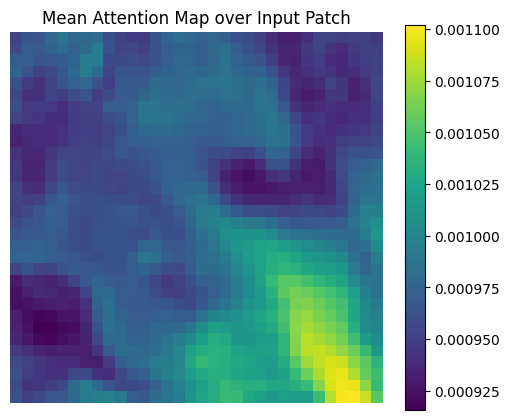

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Make sure model is in eval mode
model.eval()

# Load a few samples from your validation set
sample_batch = next(iter(val_loader))
X_sample, y_sample = sample_batch
X_sample = X_sample.to(Config.DEVICE)

# Run forward pass with attention extraction
with torch.no_grad():
    logits, attn_weights = model(X_sample[:1], return_attn=True)  # (1, num_heads, N_latents, N_inputs)

# Check shape
print("attn_weights shape:", attn_weights.shape)  # Expected: (1, num_heads, N_latents, N_inputs)

# Average across latents and heads
attn_mean = attn_weights.mean(dim=1).mean(dim=1).squeeze(0)  # (N_inputs,)

# Reshape to spatial map — assuming 32x32 patch
attn_map = attn_mean.view(32, 32).cpu().numpy()

# Plot attention map
plt.figure(figsize=(6, 5))
plt.imshow(attn_map, cmap='viridis')
plt.colorbar()
plt.title("Mean Attention Map over Input Patch")
plt.axis('off')
plt.show()


In [ ]:
print("Predicted label:", torch.argmax(logits, dim=1).item())
print("True label:     ", y_sample[0].item())


Predicted label: 0
True label:      0


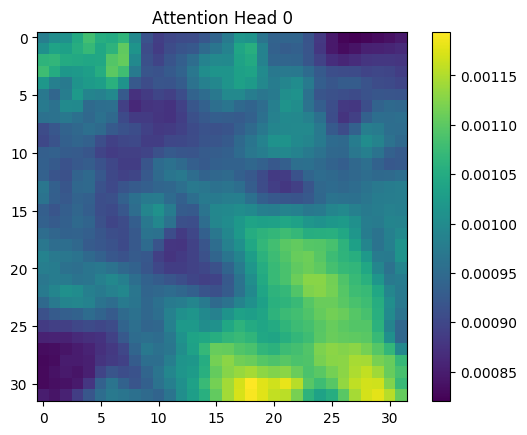

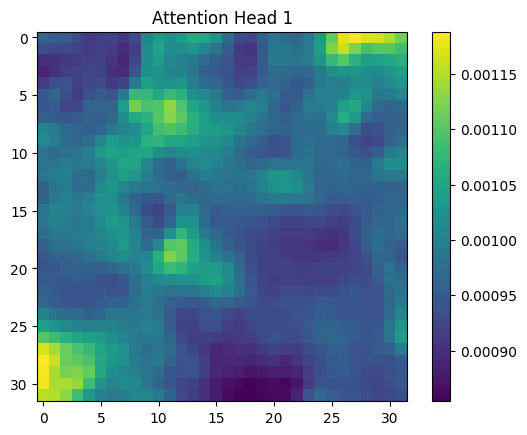

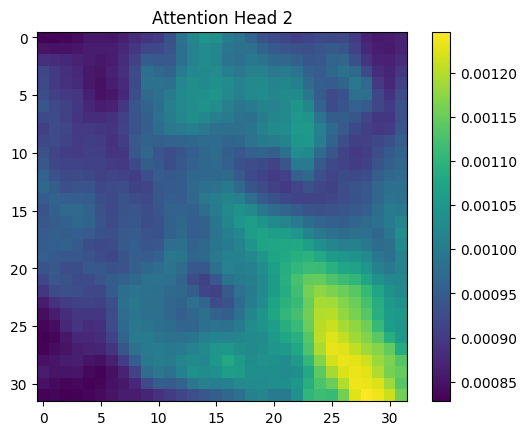

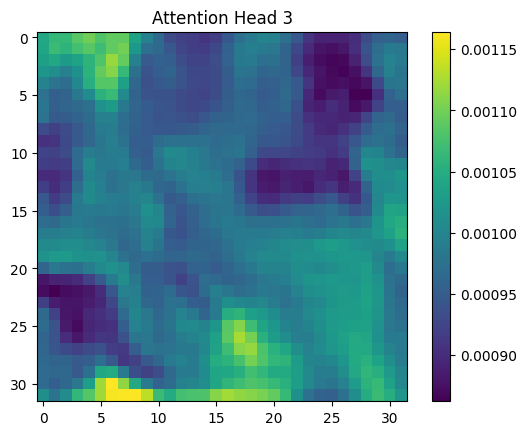

In [ ]:
for head in range(attn_weights.shape[1]):
    attn_head = attn_weights[0, head].mean(dim=0).view(32, 32).cpu().numpy()
    plt.imshow(attn_head, cmap='viridis')
    plt.title(f"Attention Head {head}")
    plt.colorbar()
    plt.show()


Predicted label: 1
True label:      1
attn_weights shape: torch.Size([1, 4, 128, 1024])


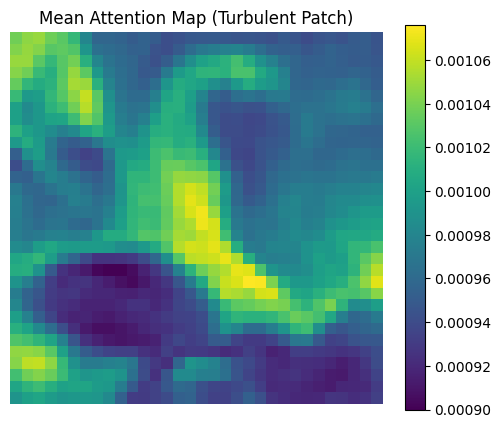

In [ ]:
idx_class1 = (y_sample == 1).nonzero(as_tuple=True)[0][0]
logits, attn_weights = model(X_sample[idx_class1:idx_class1+1], return_attn=True)
# repeat the visualization
#import torch
#import matplotlib.pyplot as plt

# -------------------------------
# 1. Find a sample with true label == 1 (Turbulent)
# -------------------------------
for i, (_, label) in enumerate(val_set):
    if label == 1:
        turbulent_idx = i
        break

# -------------------------------
# 2. Get the input sample and reshape for batch
# -------------------------------
X_turbulent, y_turbulent = val_set[turbulent_idx]
X_turbulent = X_turbulent.unsqueeze(0).to(Config.DEVICE)  # shape: (1, 3, 32, 32)

# -------------------------------
# 3. Pass through model with attention
# -------------------------------
model.eval()
with torch.no_grad():
    logits, attn_weights = model(X_turbulent, return_attn=True)
    pred_label = torch.argmax(logits, dim=1).item()

# -------------------------------
# 4. Visualize Mean Attention Map
# -------------------------------
print(f"Predicted label: {pred_label}")
print(f"True label:      {y_turbulent.item()}")
print(f"attn_weights shape: {attn_weights.shape}")  # Should be (1, num_heads, num_latents, 1024)

# Mean over heads and latents
mean_attn = attn_weights.mean(dim=(1, 2)).view(32, 32).cpu()

# Plot
plt.figure(figsize=(6, 5))
plt.imshow(mean_attn, cmap='viridis')
plt.title("Mean Attention Map (Turbulent Patch)")
plt.colorbar()
plt.axis('off')
plt.show()


<ipython-input-22-39e9563e8f75>:52: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


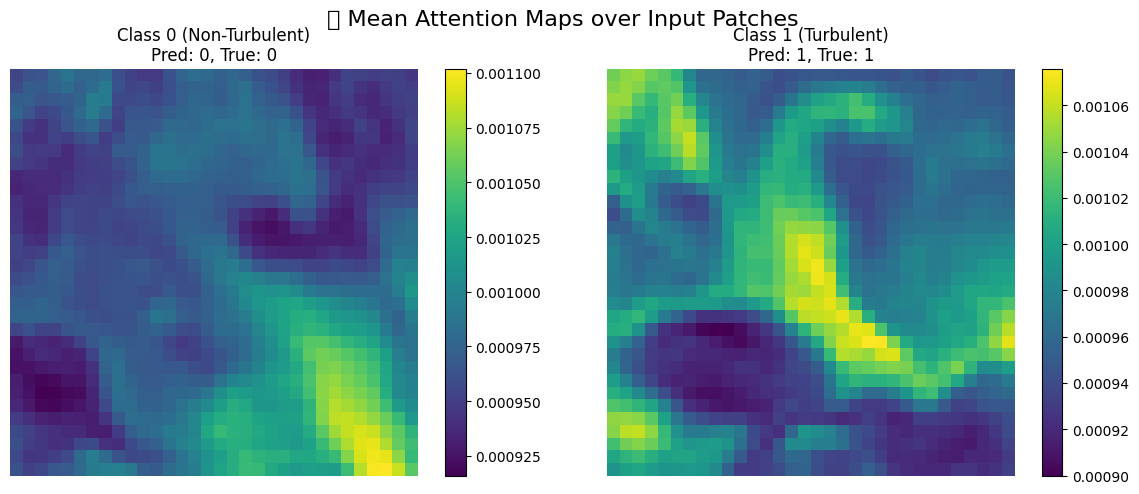

In [ ]:
import torch
import matplotlib.pyplot as plt

# -------------------------------
# 1. Find one example each from Class 0 and Class 1
# -------------------------------
idx_0 = next(i for i, (_, label) in enumerate(val_set) if label == 0)
idx_1 = next(i for i, (_, label) in enumerate(val_set) if label == 1)

X_0, y_0 = val_set[idx_0]
X_1, y_1 = val_set[idx_1]

X_0 = X_0.unsqueeze(0).to(Config.DEVICE)
X_1 = X_1.unsqueeze(0).to(Config.DEVICE)

# -------------------------------
# 2. Pass both through model
# -------------------------------
model.eval()
with torch.no_grad():
    logits_0, attn_weights_0 = model(X_0, return_attn=True)
    logits_1, attn_weights_1 = model(X_1, return_attn=True)

pred_0 = torch.argmax(logits_0, dim=1).item()
pred_1 = torch.argmax(logits_1, dim=1).item()

# -------------------------------
# 3. Compute mean attention map
# -------------------------------
def compute_mean_attention(attn):
    return attn.mean(dim=(1, 2)).view(32, 32).cpu()

map_0 = compute_mean_attention(attn_weights_0)
map_1 = compute_mean_attention(attn_weights_1)

# -------------------------------
# 4. Plot Side-by-Side
# -------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im0 = axs[0].imshow(map_0, cmap='viridis')
axs[0].set_title(f"Class 0 (Non-Turbulent)\nPred: {pred_0}, True: {y_0}")
axs[0].axis('off')
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(map_1, cmap='viridis')
axs[1].set_title(f"Class 1 (Turbulent)\nPred: {pred_1}, True: {y_1}")
axs[1].axis('off')
plt.colorbar(im1, ax=axs[1])

plt.suptitle("🔍 Mean Attention Maps over Input Patches", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
!pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# -------------------------------
# Step 4: Training Loop
# -------------------------------
best_val_acc = 0
early_stop_patience = 5

for epoch in range(1, Config.NUM_EPOCHS + 1):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(Config.DEVICE)
        y_batch = y_batch.to(Config.DEVICE)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(Config.DEVICE)
            y_batch = y_batch.to(Config.DEVICE)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, "best_model.pt")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"\n💾 Saved Best Model at Epoch {epoch} with Val Accuracy {val_acc:.4f}")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement in Val Accuracy for {epochs_no_improve} epoch(s)")

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)

    print(f"Epoch {epoch}/{Config.NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Stop training if no improvement for 'early_stop_patience' epochs
    if epochs_no_improve >= early_stop_patience:
        print(f"\n🛑 Early stopping triggered after {epoch} epochs with no improvement.")
        break
writer.close()



💾 Saved Best Model at Epoch 1 with Val Accuracy 0.5814
Epoch 1/100 | Train Loss: 0.6787 | Val Loss: 0.6711 | Train Acc: 0.5689 | Val Acc: 0.5814

💾 Saved Best Model at Epoch 2 with Val Accuracy 0.5827
Epoch 2/100 | Train Loss: 0.6788 | Val Loss: 0.6701 | Train Acc: 0.5652 | Val Acc: 0.5827

💾 Saved Best Model at Epoch 3 with Val Accuracy 0.5865
Epoch 3/100 | Train Loss: 0.6775 | Val Loss: 0.6694 | Train Acc: 0.5719 | Val Acc: 0.5865
⚠️ No improvement in Val Accuracy for 1 epoch(s)
Epoch 4/100 | Train Loss: 0.6776 | Val Loss: 0.6695 | Train Acc: 0.5729 | Val Acc: 0.5856
⚠️ No improvement in Val Accuracy for 2 epoch(s)
Epoch 5/100 | Train Loss: 0.6768 | Val Loss: 0.6680 | Train Acc: 0.5694 | Val Acc: 0.5865

💾 Saved Best Model at Epoch 6 with Val Accuracy 0.5912
Epoch 6/100 | Train Loss: 0.6764 | Val Loss: 0.6680 | Train Acc: 0.5712 | Val Acc: 0.5912

💾 Saved Best Model at Epoch 7 with Val Accuracy 0.5929
Epoch 7/100 | Train Loss: 0.6755 | Val Loss: 0.6668 | Train Acc: 0.5754 | Val Acc:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch

model.eval()
y_true = []
y_pred_probs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # ✅ this line was missing

        if outputs.shape[1] == 2:
            # Multi-class: use softmax
            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1
        else:
            # Binary: use sigmoid
            probs = torch.sigmoid(outputs).view(-1)

        y_true.extend(labels.view(-1).cpu().numpy())
        y_pred_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

print("✅ y_true shape:", y_true.shape)
print("✅ y_pred_probs shape:", y_pred_probs.shape)

def evaluate_metrics(y_true, y_pred_probs, threshold=0.40):
    y_pred = (y_pred_probs >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    print(f"✅ Accuracy:  {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    print("✅ Confusion Matrix:")
    print(cm)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm
    }

# Run the final evaluation
evaluate_metrics(y_true, y_pred_probs, threshold=0.4)


✅ y_true shape: (4508,)
✅ y_pred_probs shape: (4508,)
✅ Accuracy:  0.7646
✅ Precision: 0.7448
✅ Recall:    0.8083
✅ F1 Score:  0.7753
✅ Confusion Matrix:
[[1617  627]
 [ 434 1830]]


{'accuracy': 0.7646406388642414,
 'precision': 0.7448107448107448,
 'recall': 0.808303886925795,
 'f1_score': 0.7752594789239567,
 'confusion_matrix': array([[1617,  627],
        [ 434, 1830]])}

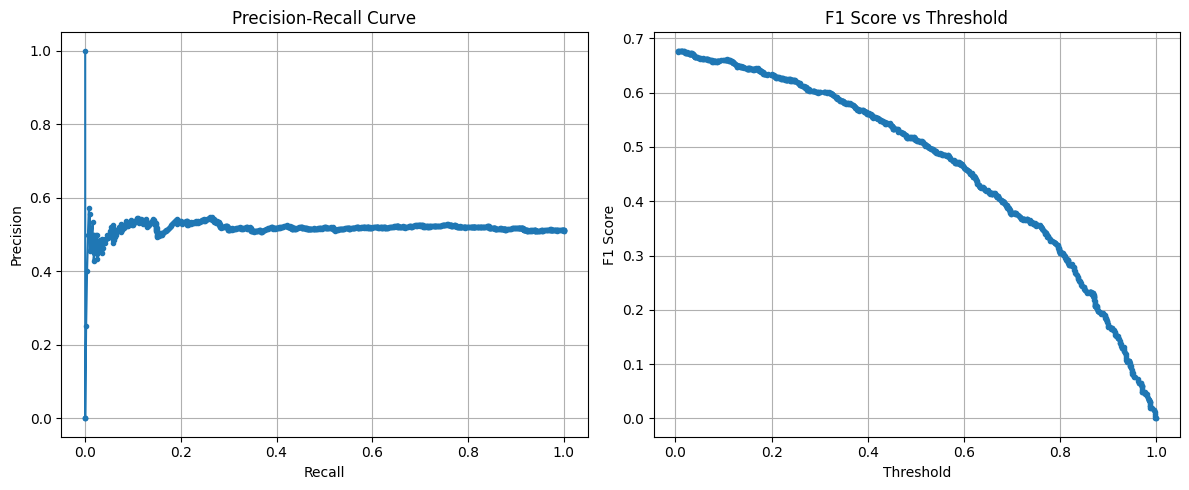

In [ ]:
# Re-import libraries after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Simulated example values (Prashant should replace with actual model outputs)
# For demonstration, these arrays simulate binary classification output
np.random.seed(42)
y_true = np.random.randint(0, 2, 1000)
y_pred_probs = np.random.rand(1000)

# Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)

# Compute F1 scores
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Plot Precision-Recall Curve and F1 vs Threshold
plt.figure(figsize=(12, 5))

# Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

# F1 Score vs Threshold
plt.subplot(1, 2, 2)
plt.plot(thresholds, f1_scores[:-1], marker='.')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)

plt.tight_layout()
plt.show()
